In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from time import perf_counter


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

import keras
from keras.datasets import mnist

In [2]:
###############
# LaTeX block #
###############

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rcParams['legend.numpoints'] = 1


def plot_cosmetics_single():
    ax = plt.gca()
    ax.tick_params(direction='in', axis='both', which='major', length=6.5, width=1.2, labelsize=16)
    ax.tick_params(direction='in', axis='both', which='minor', length=3., width=1.2, labelsize=16)
    ax.xaxis.set_tick_params(pad=7)
    ax.xaxis.labelpad = 5
    ax.yaxis.labelpad = 15
    
    
def plot_cosmetics_multi():    
    ax = plt.gca()
    ax.tick_params(direction='in', axis='both', which='major', length=6.5, width=1.2, labelsize=18)
    ax.tick_params(direction='in', axis='both', which='minor', length=3., width=1.2, labelsize=18)
    ax.xaxis.set_tick_params(pad=10)
    ax.xaxis.labelpad = 5
    ax.yaxis.labelpad = 10

### First, I will see how the data are shaped.

In [3]:
# load data from MNIST database, and split between train and test sets
# this is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images
# grayscale is represented through 8-bit values in the range [0, 255]


(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train_original = x_train
x_test_original = x_test
print(f'training part: {x_train.shape}, {y_train.shape}')
print(f'testing part: {x_test.shape}, {y_test.shape}')
print('')


# unroll the 28x28 2D images into a 28*28=784 1D reshaped array
x_train = x_train.reshape( x_train.shape[0], ( x_train.shape[1] * x_train.shape[2] ) )
x_test = x_test.reshape( x_test.shape[0], ( x_test.shape[1] * x_test.shape[2] ) )

# tensorflow will need arrays shaped as 2D column matrices
y_train = y_train.reshape( y_train.shape[0], 1 )
y_test = y_test.reshape( y_test.shape[0], 1 )

print(f'reshaped training part, for tensorflow: {x_train.shape}, {y_train.shape}')
print(f'reshaped testing part, for tensorflow: {x_test.shape}, {y_test.shape}')
print('')
print(f'the first element of X_train is in fact:\n {x_train[0]}')

training part: (60000, 28, 28), (60000,)
testing part: (10000, 28, 28), (10000,)

reshaped training part, for tensorflow: (60000, 784), (60000, 1)
reshaped testing part, for tensorflow: (10000, 784), (10000, 1)

the first element of X_train is in fact:
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253

### Here, I want to visualize a random sample of the training set.

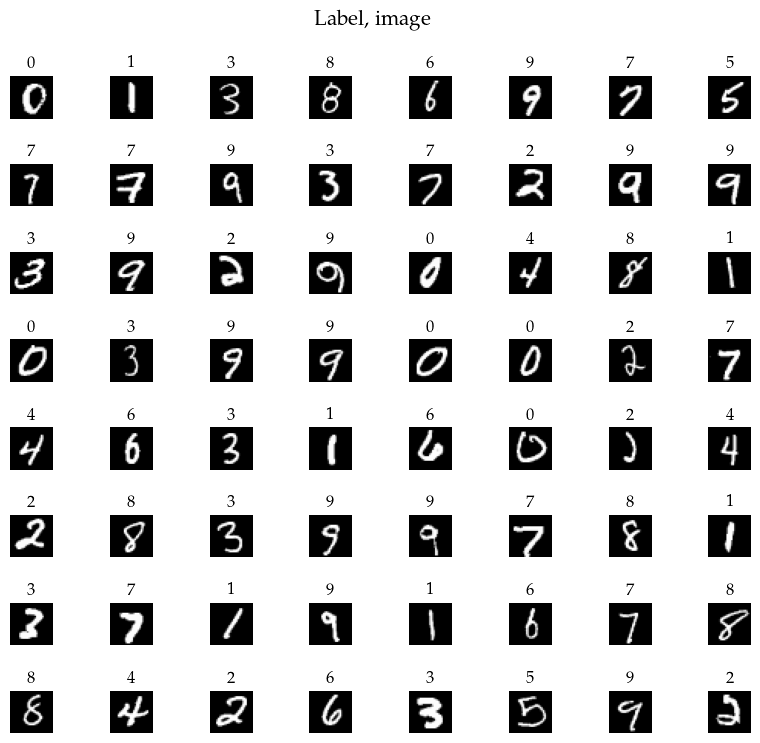

In [4]:
m, n = x_train.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91])

for i,ax in enumerate(axes.flat):
    
    random_index = np.random.randint(m)
    x_random_reshaped = x_train[random_index].reshape( (x_train_original.shape[1],x_train_original.shape[2]) )
    ax.imshow(x_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(y_train[random_index,0])
    ax.set_axis_off()
    fig.suptitle("Label, image", fontsize=15)

## <center> Class to build and use the neural network

### - Build the neural network using ReLU activation functions in the hidden layers and softmax for the output.
### - Specify loss and cost functions.
### - Train on data to minimize the cost function.

In [5]:
class HWD_NNmodel:
    
    def __init__( self, layersNum, unitsList, epochsNum ):
        self.layersNum = layersNum
        self.unitsList = unitsList
        self.epochsNum = epochsNum
        
        
    def setNNname( self, mylist ):
        string = ''
        for item in mylist[:-1]:
            string += str( item ) + '/'
        string += str( mylist[-1] )
        return string

        
    def setModel( self ):
        model = Sequential(
            [
        tf.keras.Input( shape=(x_train.shape[1],) ),
        *[ Dense( units=self.unitsList[i], activation='relu' ) for i in range( self.layersNum - 1 ) ],
        Dense( units=self.unitsList[-1], activation='linear' )
                
            ], name = 'NeuralNetwork_' + str(self.layersNum) + 'Layers_' + str( self.setNNname(self.unitsList) ) + 'Units'
        )
        return model
    
    
    def modelCompile( self, model ):
        model.compile(
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
            metrics = ['accuracy'],
        )
        return model
    
    
    def modelFit_History( self, model ):
        print('I am training the model.')
        history = model.fit( x_train, y_train, epochs=self.epochsNum )
        return history
    
    
    def Nmisclassified( self, model ):
        n = len( y_test )
        predictionProb = tf.nn.softmax( model.predict( x_test[:n] ) )
        yhat = [np.argmax( predictionProb[i] ) for i in range(n)]

        print(f'shape of the prediction probability: {predictionProb.shape}')
        print('')

        n_misclassified = 0
        for indx_y, y in enumerate(yhat):

            if y != y_test[indx_y]:
                n_misclassified += 1
        
        mse = tf.keras.losses.MeanSquaredError()
        print(f'misclassified numbers: {n_misclassified}/{len( y_test )}')
        print(f'mean squared error = {mse(y_test, yhat).numpy()}')
        return n_misclassified, mse(y_test, yhat).numpy()
    
    
    def wholeProcedure( self, model ):
        thisModel = self.setModel()
        thisModel.summary()
        thisModelCompiled = self.modelCompile( thisModel )
        self.modelFit_History( thisModelCompiled )
        n_mis, mse_np = self.Nmisclassified( thisModel )
        
        return n_mis, mse_np

In [6]:
## Example ##

MyNN = HWD_NNmodel(4, [35, 25, 15, 10], 40)
myModel = MyNN.setModel()
myModel.summary()
myModel_compiled = MyNN.modelCompile( myModel )

start_time = perf_counter()
myModel_history = MyNN.modelFit_History( myModel_compiled )
stop_time = perf_counter()

print('')
print(f'The data set has gone through the model {len( myModel_history.history["loss"] )} times (epochs). The data set is divided into {int(x_train.shape[0])} / 32 = {int(x_train.shape[0] / 32)} batches.')
print(f'It took {stop_time - start_time} seconds.')

Model: "NeuralNetwork_4Layers_35/25/15/10Units"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 35)                27475     
                                                                 
 dense_1 (Dense)             (None, 25)                900       
                                                                 
 dense_2 (Dense)             (None, 15)                390       
                                                                 
 dense_3 (Dense)             (None, 10)                160       
                                                                 
Total params: 28925 (112.99 KB)
Trainable params: 28925 (112.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
I am training the model.
Epoch 1/40
1875/1875 [==============================] - 1s 688us/step - loss: 1.5446 - accuracy: 

Model metrics: ['loss', 'accuracy']


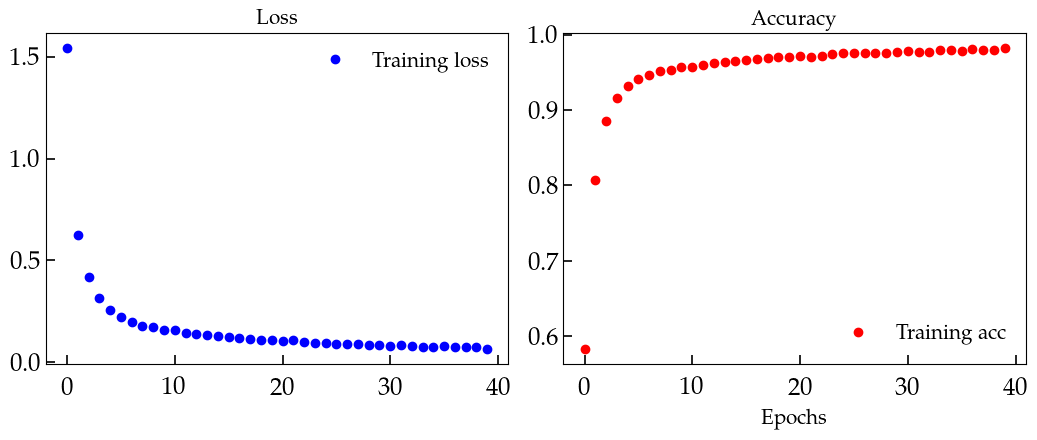

In [7]:
## Example above ##

print(f'Model metrics: {myModel.metrics_names}')
Epochs = myModel_history.epoch
acc = myModel_history.history['accuracy']
loss = myModel_history.history['loss']


plt.figure(figsize=(10.5, 4.5))
plt.subplot(1, 2, 1)
plot_cosmetics_multi()
plt.plot(Epochs, loss, 'o', color='blue', label='Training loss')
plt.title('Loss', fontsize=15)
plt.legend(frameon=False, fontsize=15)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()
plt.plot(Epochs, acc, 'o', color='red', label='Training acc')
plt.title('Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.legend(frameon=False, fontsize=15)
plt.tight_layout()

In [8]:
def display_errors(model,X,y):
    
    f = model.predict(X)
    yhat = np.argmax(f, axis=1)
    doo = yhat != y[:,0]
    idxs = np.where(yhat != y[:,0])[0]
    if len(idxs) == 0:
        print("no errors found")
    else:
        cnt = min(8, len(idxs))
        fig, ax = plt.subplots(1, cnt, figsize=(5,1.2))
        fig.tight_layout(pad=0.13, rect=[0, 0.03, 1, 0.80])
        
        for i in range(cnt):
            j = idxs[i]
            X_reshaped = X[j].reshape( (x_train_original.shape[1], x_train_original.shape[2]) )

            # Display the image
            ax[i].imshow(X_reshaped, cmap='gray')

            # Predict using the Neural Network
            prediction = model.predict(X[j].reshape( 1, x_train_original.shape[1]*x_train_original.shape[2] ))
            prediction_p = tf.nn.softmax(prediction)
            yhat = np.argmax(prediction_p)

            # Display the label above the image
            ax[i].set_title(f"{y[j,0]},{yhat}",fontsize=13)
            ax[i].set_axis_off()
            fig.suptitle("$y_{\mathrm{true}}, y_{\mathrm{predicted}}$", fontsize=13, y=1.05)
            
    return( len(idxs) )

1/1 [==============================] - 0s 7ms/step
421 errors out of 10000 images


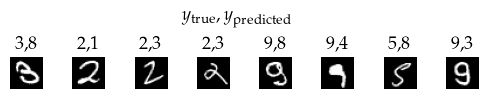

In [9]:
## Example above ##

print( f"{display_errors(myModel, x_test , y_test)} errors out of {len(x_test)} images")

## <center> Model selection

In [10]:
MyNN_comparison_1 = HWD_NNmodel(4, [35, 25, 15, 10], 20)
myModel_1 = MyNN_comparison_1.setModel()
MyNN_comparison_2 = HWD_NNmodel(3, [30, 20, 10], 20)
myModel_2 = MyNN_comparison_2.setModel()
MyNN_comparison_3 = HWD_NNmodel(3, [40, 25, 10], 20)
myModel_3 = MyNN_comparison_3.setModel()


print('*** Beginning ***')
n_mis1, mse1 = MyNN_comparison_1.wholeProcedure( myModel_1 )
print('*** End ***')
print('')
print('*** Beginning ***')
n_mis2, mse2 = MyNN_comparison_2.wholeProcedure( myModel_2 )
print('*** End ***')
print('')
print('*** Beginning ***')
n_mis3, mse3 = MyNN_comparison_3.wholeProcedure( myModel_3 )
print('*** End ***')

*** Beginning ***
Model: "NeuralNetwork_4Layers_35/25/15/10Units"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 35)                27475     
                                                                 
 dense_15 (Dense)            (None, 25)                900       
                                                                 
 dense_16 (Dense)            (None, 15)                390       
                                                                 
 dense_17 (Dense)            (None, 10)                160       
                                                                 
Total params: 28925 (112.99 KB)
Trainable params: 28925 (112.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
I am training the model.
Epoch 1/20
1875/1875 [==============================] - 1s 663us/step - loss: 1

1875/1875 [==============================] - 1s 577us/step - loss: 0.1474 - accuracy: 0.9584
Epoch 9/20
1875/1875 [==============================] - 1s 575us/step - loss: 0.1346 - accuracy: 0.9628
Epoch 10/20
1875/1875 [==============================] - 1s 582us/step - loss: 0.1297 - accuracy: 0.9642
Epoch 11/20
1875/1875 [==============================] - 1s 591us/step - loss: 0.1208 - accuracy: 0.9663
Epoch 12/20
1875/1875 [==============================] - 1s 579us/step - loss: 0.1146 - accuracy: 0.9674
Epoch 13/20
1875/1875 [==============================] - 1s 577us/step - loss: 0.1089 - accuracy: 0.9695
Epoch 14/20
1875/1875 [==============================] - 1s 575us/step - loss: 0.1040 - accuracy: 0.9714
Epoch 15/20
1875/1875 [==============================] - 1s 579us/step - loss: 0.1003 - accuracy: 0.9720
Epoch 16/20
1875/1875 [==============================] - 1s 577us/step - loss: 0.0953 - accuracy: 0.9731
Epoch 17/20
1875/1875 [==============================] - 1s 584us/st

In [11]:
print(f'Misclassified digits and MSE.\n')
print(f'Model 1: N = {n_mis1}, MSE = {mse1}')
print(f'Model 2: N = {n_mis2}, MSE = {mse2}')
print(f'Model 3: N = {n_mis3}, MSE = {mse3}')

Misclassified digits and MSE.

Model 1: N = 390, MSE = 16
Model 2: N = 627, MSE = 16
Model 3: N = 393, MSE = 16
